<a href="https://colab.research.google.com/github/Ayasaberomran/first/blob/main/Medical_Image_Captioning_with_BLIP_%E2%80%94_Chest_X_ray_Interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Why Use Bootstrapping BLIP (BLIP)

BLIP (Bootstrapping Language-Image Pretraining) is a powerful Vision-Language model designed to:

✅ Generate captions for images by combining visual and textual understanding.

✅ Perform zero-shot tasks like image-to-text without needing task-specific training.

✅ Achieve state-of-the-art results on image captioning benchmarks (e.g., COCO).

✅ Be easily loaded from Hugging Face for fast prototyping.

In a medical setting (e.g., chest X-ray):

BLIP can automatically describe radiological findings, which helps clinicians save time.

Even without being trained on medical images, BLIP offers a strong general baseline.

It can later be fine-tuned on specialized medical datasets like MIMIC-CXR.



# **Dataset Download From kaggle _ using Kaggle Api **

In [1]:

from google.colab import files
files.upload()


Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"ayasaber","key":"23e1f21c7e30959c9a23d3269a24461f"}'}

In [6]:
# kaggle config directory
!mkdir -p /root/.config/kaggle
!cp 'kaggle (1).json' /root/.config/kaggle/kaggle.json
!chmod 600 /root/.config/kaggle/kaggle.json



In [7]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

api.dataset_download_files('paultimothymooney/chest-xray-pneumonia', path='./data', unzip=True)



Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


# PRoject Start _ Import lib

In [8]:
# Import essential libraries
from PIL import Image                            # For opening and processing images
import torch                                     # PyTorch for tensor operations
from transformers import BlipProcessor, BlipForConditionalGeneration  # BLIP model and processor from Hugging Face

import matplotlib.pyplot as plt             # To display the image
from transformers import BlipForConditionalGeneration
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
import torch


In [9]:
# Load pretrained BLIP processor and model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [10]:

#  Select a chest X-ray image from the dataset
image_path = "/content/data/chest_xray/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg"  # You can replace this with any image path
image = Image.open(image_path).convert('RGB')  # Convert to RGB mode (BLIP requires 3 channels)


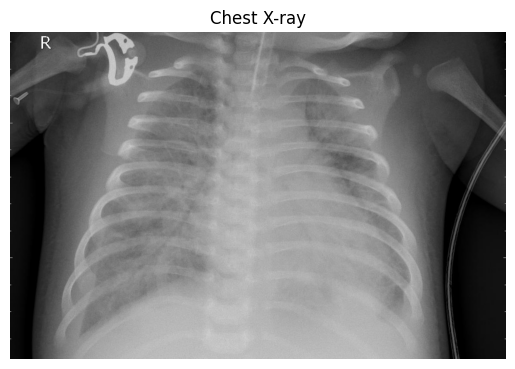

In [11]:
# Step 4: Display the image using matplotlib
plt.imshow(image)
plt.axis("off")
plt.title("Chest X-ray")
plt.show()


In [12]:
# Step 5: Preprocess the image and prepare input for BLIP
inputs = processor(images=image, return_tensors="pt")  # Convert image to tensor format for the model


In [13]:
# Step 6: Generate the caption using BLIP
output = model.generate(**inputs)  # Model generates token output (caption)
caption = processor.decode(output[0], skip_special_tokens=True)  # Decode tokens to string

In [14]:

# Step 7: Print the generated medical caption
print("🩺 AI-Generated Medical Caption:", caption)

🩺 AI-Generated Medical Caption: a chest with a large rib fracture


# Fine-tuning the BLIP Model on Medical X-ray Data

(Fine-tuning with Pseudo-Captions):

In [15]:
import os
import pandas as pd

# Set the base dataset path
base_path = "/content/data/chest_xray/chest_xray/train"



In [16]:
# Prepare lists to hold image info
image_paths = []
labels = []
captions = []


In [17]:

# Loop over both NORMAL and PNEUMONIA folders
for label in ["NORMAL", "PNEUMONIA"]:
    folder_path = os.path.join(base_path, label)
    for fname in os.listdir(folder_path):
        if fname.endswith(".jpeg") or fname.endswith(".jpg"):
            full_path = os.path.join(folder_path, fname)
            image_paths.append(full_path)
            labels.append(label)
            # Assign pseudo-captions based on the label
            if label == "NORMAL":
                captions.append("A normal chest x-ray.")
            else:
                captions.append("A chest x-ray showing pneumonia.")


In [18]:

# Create a DataFrame
df = pd.DataFrame({
    "image_path": image_paths,
    "label": labels,
    "pseudo_caption": captions
})

# Save to CSV
df.to_csv("train_pseudo_caption.csv", index=False)

print(" CSV generated with pseudo-captions!")
df.head()


 CSV generated with pseudo-captions!


,image_path,label,pseudo_caption
0,/content/data/chest_xray/chest_xray/train/NORM...,NORMAL,A normal chest x-ray.
1,/content/data/chest_xray/chest_xray/train/NORM...,NORMAL,A normal chest x-ray.
2,/content/data/chest_xray/chest_xray/train/NORM...,NORMAL,A normal chest x-ray.
3,/content/data/chest_xray/chest_xray/train/NORM...,NORMAL,A normal chest x-ray.
4,/content/data/chest_xray/chest_xray/train/NORM...,NORMAL,A normal chest x-ray.


In [19]:
from torch.utils.data import Dataset
from PIL import Image

class ChestXrayCaptionDataset(Dataset):
    def __init__(self, csv_file, processor):
        """
        Args:
            csv_file (str): Path to the CSV file containing image paths and captions.
            processor (BlipProcessor): Processor to prepare image and text.
        """
        self.data = pd.read_csv(csv_file)
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get image path and caption
        image_path = self.data.iloc[idx]["image_path"]
        caption = self.data.iloc[idx]["pseudo_caption"]

        # Open and convert image to RGB
        image = Image.open(image_path).convert("RGB")

        # Process image and text together (for training)
        inputs = self.processor(images=image, text=caption, return_tensors="pt", padding="max_length", truncation=True)

        # Remove batch dimension (squeeze)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        return inputs


In [20]:
class ChestXrayCaptionDataset(Dataset):
    def __init__(self, csv_file, processor):
        self.data = pd.read_csv(csv_file)
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]["image_path"]
        caption = self.data.iloc[idx]["pseudo_caption"]
        image = Image.open(image_path).convert("RGB")

        inputs = self.processor(
            images=image,
            text=caption,
            return_tensors="pt",
            padding="max_length",      # ✅ مهم
            truncation=True,
            max_length=50
        )

        # Remove batch dimension
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        return inputs


In [21]:
from torch.utils.data import DataLoader
from transformers import BlipProcessor

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

# Initialize the dataset
train_dataset = ChestXrayCaptionDataset(csv_file="train_pseudo_caption.csv", processor=processor)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Test one batch
batch = next(iter(train_loader))
print(batch.keys())  # Should show: input_ids, pixel_values, attention_mask
print(batch["input_ids"].shape, batch["pixel_values"].shape)


dict_keys(['pixel_values', 'input_ids', 'attention_mask'])
torch.Size([8, 50]) torch.Size([8, 3, 384, 384])


Validation

In [22]:
import os
import pandas as pd

# Base path for validation data
val_path = "/content/data/chest_xray/val"

# Prepare data lists
image_paths = []
labels = []
captions = []

# Loop through each label
for label in ["NORMAL", "PNEUMONIA"]:
    folder = os.path.join(val_path, label)
    for fname in os.listdir(folder):
        if fname.endswith(".jpeg") or fname.endswith(".jpg"):
            full_path = os.path.join(folder, fname)
            image_paths.append(full_path)
            labels.append(label)
            if label == "NORMAL":
                captions.append("A normal chest x-ray.")
            else:
                captions.append("A chest x-ray showing pneumonia.")

# Create and save DataFrame
df_val = pd.DataFrame({
    "image_path": image_paths,
    "label": labels,
    "pseudo_caption": captions
})

df_val.to_csv("val_pseudo_caption.csv", index=False)

print("✅ val_pseudo_caption.csv created successfully!")


✅ val_pseudo_caption.csv created successfully!


MODEL Training

In [28]:
from transformers import BlipForConditionalGeneration
from torch.optim import AdamW
from tqdm import tqdm
import torch

# Load fine-tuned BLIP model
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)



BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

In [29]:

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)


In [30]:

# Load datasets
train_dataset = ChestXrayCaptionDataset(csv_file="train_pseudo_caption.csv", processor=processor)
val_dataset   = ChestXrayCaptionDataset(csv_file="val_pseudo_caption.csv", processor=processor)


In [31]:

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8)


In [32]:

# Training loop
num_epochs = 3
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} - Training"):
        pixel_values = batch["pixel_values"].to(device)
        input_ids    = batch["input_ids"].to(device)

        # Forward pass: same input as labels
        outputs = model(pixel_values=pixel_values, input_ids=input_ids, labels=input_ids)
        loss = outputs.loss

        # Backward + optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation loop (after entire training loop)
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            pixel_values = batch["pixel_values"].to(device)
            input_ids    = batch["input_ids"].to(device)

            outputs = model(pixel_values=pixel_values, input_ids=input_ids, labels=input_ids)
            val_loss = outputs.loss
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model.save_pretrained("best_blip_model")
        processor.save_pretrained("best_blip_model")
        print("✅ Best model saved.")


Epoch 1 - Training: 100%|██████████| 652/652 [17:18<00:00,  1.59s/it]



📊 Epoch 1 Summary:
Train Loss: 0.4714 | Val Loss: 0.0070
✅ Best model saved.


Epoch 2 - Training: 100%|██████████| 652/652 [17:06<00:00,  1.57s/it]



📊 Epoch 2 Summary:
Train Loss: 0.0039 | Val Loss: 0.0017
✅ Best model saved.


Epoch 3 - Training: 100%|██████████| 652/652 [17:08<00:00,  1.58s/it]



📊 Epoch 3 Summary:
Train Loss: 0.0021 | Val Loss: 0.0023


In [33]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch

# Load fine-tuned model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = BlipForConditionalGeneration.from_pretrained("best_blip_model").to(device)
processor = BlipProcessor.from_pretrained("best_blip_model")

# Load test image
image_path = "./data/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg"  # ✅ غيّري المسار لأي صورة
image = Image.open(image_path).convert("RGB")

# Preprocess
inputs = processor(images=image, return_tensors="pt").to(device)

# Generate caption
model.eval()
with torch.no_grad():
    output_ids = model.generate(**inputs, max_length=50)
    caption = processor.decode(output_ids[0], skip_special_tokens=True)

print("🩺 Caption:", caption)


🩺 Caption: a chest x - ray showing pneumonia.


GENRATING CAPTIONS FOR TEST SET

In [37]:
import os
import pandas as pd
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch
from tqdm import tqdm

# Load fine-tuned model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = BlipForConditionalGeneration.from_pretrained("best_blip_model").to(device)
processor = BlipProcessor.from_pretrained("best_blip_model")

# Set test directory
test_dir = "/content/data/chest_xray/test"
categories = os.listdir(test_dir)

# Store results
results = []

# Loop through test images
for category in categories:
    category_path = os.path.join(test_dir, category)
    if not os.path.isdir(category_path):
        continue
    for filename in tqdm(os.listdir(category_path), desc=f"Processing {category}"):
        img_path = os.path.join(category_path, filename)
        try:
            image = Image.open(img_path).convert("RGB")
            inputs = processor(images=image, return_tensors="pt").to(device)
            output_ids = model.generate(**inputs, max_length=50)
            caption = processor.decode(output_ids[0], skip_special_tokens=True)

            results.append({
                "image_path": img_path,
                "true_label": category,
                "generated_caption": caption
            })
        except Exception as e:
            print(f"❌ Skipped {img_path}: {e}")
            continue

# Save to CSV
df = pd.DataFrame(results)
df.to_csv("test_generated_captions.csv", index=False)

print("✅ Captions generated and saved to test_generated_captions.csv")



Processing NORMAL: 100%|██████████| 234/234 [01:09<00:00,  3.39it/s]

✅ Captions generated and saved to test_generated_captions.csv


/tmp/ipython-input-38-3575647337.py:25: UserWarning: Glyph 129658 (\N{STETHOSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-38-3575647337.py:25: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129658 (\N{STETHOSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


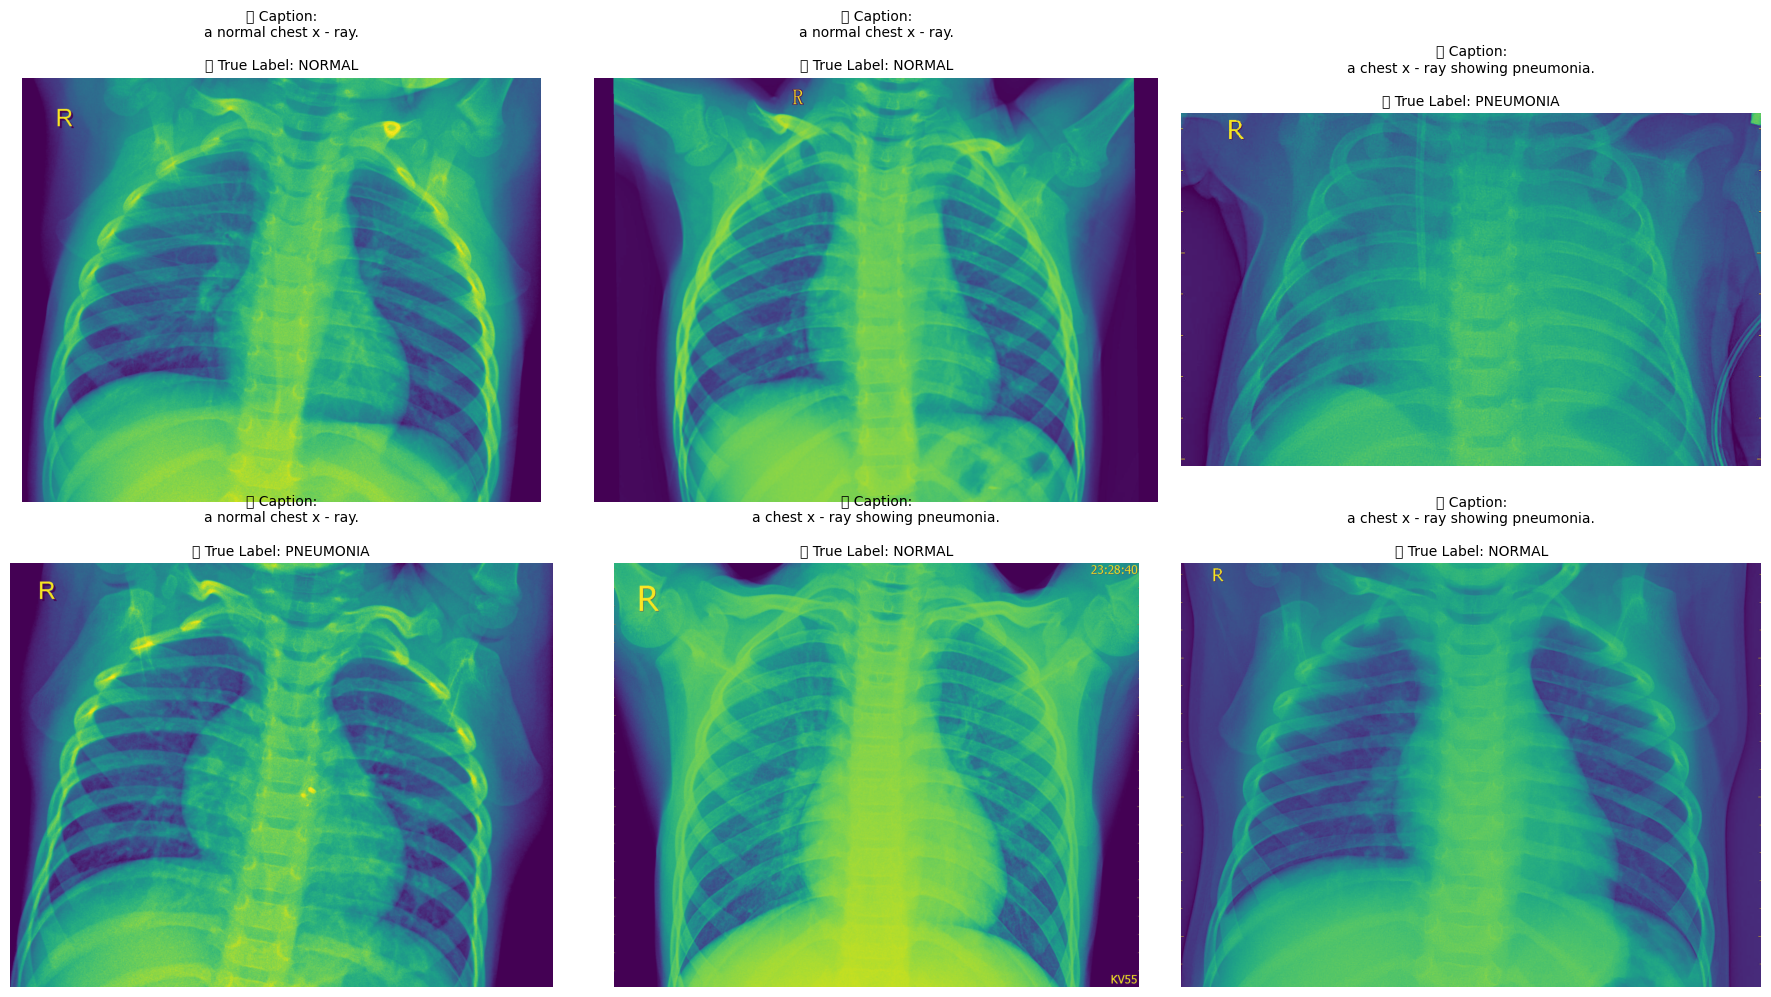

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Load the generated captions CSV
df = pd.read_csv("test_generated_captions.csv")

# 🧪 Sample 6 images (أو اختاري أي عدد)
sample_df = df.sample(6, random_state=42)

# 🖼️ إعداد الشكل
plt.figure(figsize=(18, 10))

for i, row in enumerate(sample_df.itertuples()):
    img = Image.open(row.image_path)

    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.axis('off')

    # 📝 عرض الكابشن والليبل
    plt.title(f"🩺 Caption:\n{row.generated_caption}\n\n🎯 True Label: {row.true_label}",
              fontsize=10, color='black')

plt.tight_layout()
plt.show()
